# preamble

In [1]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.animation import FuncAnimation
import os
from xmitgcm import open_mdsdataset
from xmitgcm.utils import get_grid_from_input, get_extra_metadata
import xgcm
from scipy.interpolate import interp1d

from myutils import *
from MITgcmutils import llc
import xarray as xr
import cmocean.cm as cmo
#import cartopy.crs as ccrs
import cartopy as cart
# Nils stuff, this is necessary
import matplotlib
import cartopy

## general functions

In [2]:
def sq(a):
    import numpy as np
    a = np.squeeze(a)
    masked_array=np.ma.masked_where(a==0., a)
    return masked_array

def symNorm(vmax):
    import matplotlib.colors as mcolors
    return mcolors.Normalize(vmin=-vmax,vmax=vmax)

face_connections = {'face':
                    {0: {'X':  ((12, 'Y', False), (3, 'X', False)),
                         'Y':  (None,             (1, 'Y', False))},
                     1: {'X':  ((11, 'Y', False), (4, 'X', False)),
                         'Y':  ((0, 'Y', False),  (2, 'Y', False))},
                     2: {'X':  ((10, 'Y', False), (5, 'X', False)),
                         'Y':  ((1, 'Y', False),  (6, 'X', False))},
                     3: {'X':  ((0, 'X', False),  (9, 'Y', False)),
                         'Y':  (None,             (4, 'Y', False))},
                     4: {'X':  ((1, 'X', False),  (8, 'Y', False)),
                         'Y':  ((3, 'Y', False),  (5, 'Y', False))},
                     5: {'X':  ((2, 'X', False),  (7, 'Y', False)),
                         'Y':  ((4, 'Y', False),  (6, 'Y', False))},
                     6: {'X':  ((2, 'Y', False),  (7, 'X', False)),
                         'Y':  ((5, 'Y', False),  (10, 'X', False))},
                     7: {'X':  ((6, 'X', False),  (8, 'X', False)),
                         'Y':  ((5, 'X', False),  (10, 'Y', False))},
                     8: {'X':  ((7, 'X', False),  (9, 'X', False)),
                         'Y':  ((4, 'X', False),  (11, 'Y', False))},
                     9: {'X':  ((8, 'X', False),  None),
                         'Y':  ((3, 'X', False),  (12, 'Y', False))},
                     10: {'X': ((6, 'Y', False),  (11, 'X', False)),
                          'Y': ((7, 'Y', False),  (2, 'X', False))},
                     11: {'X': ((10, 'X', False), (12, 'X', False)),
                          'Y': ((8, 'Y', False),  (1, 'X', False))},
                     12: {'X': ((11, 'X', False), None),
                          'Y': ((9, 'Y', False),  (0, 'X', False))}}}

def make_masks(coords):
    global_mask = coords.hFacC.isel(k=0)
    global_mask[6,:,:]=0. # delete Arctic face
    global_mask[2,80:,60:]=0.
    global_mask[7,:,:13]=0.
    global_mask[10,:43,:11]=0.
    # remove Hudson
    global_mask[10,30:54,5:39] = 0.
    global_mask[10,30:62,10:39] = 0.
    # remove Carribean

    #
    atlantic_mask = global_mask.where(coords.YC>-35).where( # Southern Ocean
        np.logical_and(coords.XC<20,coords.XC>-98)).where( # most of the non-Atlantic Ocean
        np.logical_or(coords.XC<0,np.logical_or(coords.YC<30,coords.YC>47))).where(
        np.logical_or(coords.XC<-9,np.logical_or(coords.YC<34,coords.YC>38))).where( # Strait of Gibraltar
        np.logical_or(coords.XC>-70,coords.YC>9)).where( # East Pacific
        np.logical_or(coords.XC>-84,coords.YC>14)).where( # Isthmus of Panama etc.
        np.logical_or(coords.XC>-90,coords.YC>18)).where(
        np.logical_or(coords.XC>-70,coords.YC<50)).fillna(0)
    indopacific_mask = (global_mask-atlantic_mask).where(
        np.logical_and(coords.YC>-35,coords.YC<70)).fillna(0)
    # remove Hudson
    indopacific_mask[10,10:,:39] = 0.
    # remove Med and parts of Arctic
    indopacific_mask[ 2,20:,29:84] = 0.
    # remove Bering strait and Chukchy Sea
    indopacific_mask[ 7,:,:14] = 0.
    return global_mask, atlantic_mask, indopacific_mask

def flat2d(x):
    if type(x) is np.ndarray:
        x0 = np.concatenate( [np.concatenate([x[:,0,:,:],x[:,1,:,:],x[:,2,:,:]], axis=-2),
                              np.concatenate([x[:,3,:,:],x[:,4,:,:],x[:,5,:,:]], axis=-2)], axis=-1 )
        y0 = np.concatenate( [np.concatenate([x[:,7,:,:],x[:,8,:,:],x[:,9,:,:]], axis=-1),
                              np.concatenate([x[:,10,:,:],x[:,11,:,:],x[:,12,:,:]], axis=-1)], axis=-2 )
    else:
        x0 = xr.concat( [xr.concat( [x.isel(face=0),x.isel(face=1),x.isel(face=2)], dim = 'j' ),
                         xr.concat( [x.isel(face=3),x.isel(face=4),x.isel(face=5)], dim = 'j' )], dim='i' )
        y0 = xr.concat( [xr.concat( [x.isel(face=7),x.isel(face=8),x.isel(face=9)], dim = 'i' ),
                         xr.concat( [x.isel(face=10),x.isel(face=11),x.isel(face=12)], dim = 'i' )], dim='j' )
    return np.concatenate((x0,np.rot90(y0,k=1,axes=(-2,-1))), axis=-1)

def zonal_mean(ds,fld,msk):
    # mask the Med
    dvol = flat2d(ds.hFacC*ds.rA*ds.drF*msk)
    # mask the Med
    dvol[:,200:217,33:80]=0
    dvol[:,217:222,40:60]=0
    ra = dvol.sum(axis=-1)
    ra[ra==0]=np.Inf
    fldz = (flat2d(fld)*dvol).sum(axis=-1)/ra
    return np.ma.masked_array(fldz,fldz==0)

def zonal_sum(fld):
    # zonal integral of scalar field
    return flat2d(fld).sum(axis=-1)
    
def calc_flux_divergence(dl):
    # this is done separately
    # grd = xgcm.Grid(dl, periodic=False, face_connections=face_connections)
    # layer flux in two directions
    flxx = dl.LaUH1RHO*dl.dyG
    flxy = dl.LaVH1RHO*dl.dxG
    # difference in the x and y directions
    diff_flx = grd.diff_2d_vector({'X': flxx, 'Y': flxy}, boundary='fill')
    # divergence
    return diff_flx['X'] + diff_flx['Y']

def calc_wflux_dia(dl):
    flx_div = calc_flux_divergence(dl)
    # compute wflux at w-points (above c-points) by reversing the k-axis,
    # integrating (now from the bottom up) cumulatively,
    # assuming wflx=0 at n+1
    wflux = -flx_div.reindex(l1_c=flx_div.l1_c[::-1]).cumsum(dim='l1_c')
    # and reverse the k-axis again
    return wflux.reindex(l1_c=wflux.l1_c[::-1])

## MOC functions

In [3]:
def compute_moc_layers(dl,msk):
    wflux = calc_wflux_dia(dl)
    return compute_moc(wflux*msk)

def compute_moc(wflux):
    # zonal integral
    wflx = zonal_sum(wflux)
    # order of integration: from north to south because of Atlantic MOC, requires sign change
    mocstrf = -np.flip(np.flip(wflx,axis=-1).cumsum(axis=-1),axis=-1)
    mocstrf[wflx==0]=0.
    return mocstrf

def compute_layers(dl,msk):
    grd = xgcm.Grid(dl, periodic=False, face_connections=face_connections)
    lahc = grd.interp_2d_vector({'X': dl.LaHw1RHO, 
                                 'Y': dl.LaHs1RHO},
                                 to = 'center', boundary='fill')
    lath = 0.5*(lahc['X']+lahc['Y'])*msk
    zz = flat2d(lath).cumsum(axis=0)
    return zz.mean(axis=-1,where=zz!=0)

# Paths and names

In [4]:
deltat=3600.
ny, nx = 1170, 90
# prefix=['diagsKrN2']

ctrlrun='run15'
bdir='/work/ollie/mlosch/idemix_test/llc90'
gdir='/work/ollie/mlosch/idemix_test/llc90/grid'
fdir='/home/ollie/mlosch/MITgcm/MITgcm/idemix_test/llc90/figs'
rdir0=os.path.join(bdir,ctrlrun) # like run01 with 60 days for salinity restoring, 10m/60days = 1.9290123456790124e-06 m/s)
rdir1=os.path.join(bdir,'%s_jayne'%ctrlrun) #'/work/ollie/mlosch/idemix_test/llc90/run03_jayne' # same as run03 with idemix, jayne-forcing
rdir2=os.path.join(bdir,'%s_nycander'%ctrlrun)
rdir3=os.path.join(bdir,'%s_stormtide'%ctrlrun)
#rdir2='/work/ollie/mlosch/idemix_test/llc90/run03_nycander' # same as run03 with idemix, nycander-forcing
#rdir3='/work/ollie/mlosch/idemix_test/llc90/run03_stormtide' # same as run03 with idemix, stormtide-forcing

postprocdir = os.path.join(bdir,'postprocessing')

rname0='CTRL'
rname1='JAYNE'
rname2='NYCANDER'
rname3='STORMTIDE'

rnames = [rname0,rname1,rname2,rname3]
#rnames= [rname0,rname1,rname2]
#rnames= [rname2]
rdirs = []
for rname in rnames:
    if rname==rname0:
        rdirs.append(rdir0)
    else:
        rdirs.append(os.path.join(bdir,'%s_%s'%(ctrlrun,rname.lower())))

# find out the file numbers to read
cycle = 5
startyear = 1958
refdate = "%i-1-1 0:0:0"%(startyear-(cycle-1)*62)
mycycle = "cycle%i"%(cycle)

fnames = ['REF', 'Jayne', 'LINEAR', 'STORM']
rdirs = [rdirs[0]]
rnames = [rnames[0]]

# select the last 40 years of the last (5th) cycle and compute the mean (to be kept in memory)

In [5]:
year0,year1 = '1980','2020'
#year0,year1 = '1980','1998'
yearstr = year1
do_compute=False

In [6]:
dsm=[]
dlm=[]
if do_compute:
    for k,ds in enumerate(dss):
        print("means: processing %s"%rnames[k])
        dsm.append(ds.sel(time=slice(year0,year1)).mean(dim='time').compute())
        dsm[k].to_netcdf(os.path.join(postprocdir,"%s_%s.nc"%(rnames[k],mycycle)))
    # also for the layers output
    for k, ds in enumerate(dls):
        print("layer means: processing %s"%rnames[k])
        dlm.append(ds.sel(time=slice(year0,year1)).mean(dim='time').compute())
        dlm[k].to_netcdf(os.path.join(postprocdir,"%s_layers_%s.nc"%(rnames[k],mycycle)))
else:
    for rname in rnames:
        dsm.append(xr.open_dataset(os.path.join(postprocdir,"%s_%s.nc"%(rname,mycycle))))
        dlm.append(xr.open_dataset(os.path.join(postprocdir,"%s_layers_%s.nc"%(rname,mycycle))))

In [7]:
# We generate the extra metadata needed for multi-faceted grids
llc90_extra_metadata = get_extra_metadata(domain='llc', nx=90)
grid = get_grid_from_input(os.path.join('/home/ollie/mlosch/MITgcm/nils/llc90/input','tile<NFACET>.mitgrid'),
                           geometry='llc', extra_metadata=llc90_extra_metadata)

## fix coordinates

In [8]:
coords = dlm[0].coords.to_dataset()
coords['XC'] = grid.XC
coords['YC'] = grid.YC
coords['XG'] = grid.XG
coords['YG'] = grid.YG

grd = xgcm.Grid(dlm[0], periodic=False, face_connections=face_connections)


# Overturning

In [9]:
def compute_layers(dl,msk):
    grd = xgcm.Grid(dl, periodic=False, face_connections=face_connections)
    lahc = grd.interp_2d_vector({'X': dl.LaHw1RHO, 
                                 'Y': dl.LaHs1RHO},
                                 to = 'center', boundary='fill')
    lath = 0.5*(lahc['X']+lahc['Y'])*msk
    # not sure if this is better or worse, but does not make much of a difference
    #lath = np.maximum(lahc['X'],lahc['Y'])*msk
    zzz = flat2d(lath)
    # first do the zonal average
    zz = zzz.mean(axis=-1,where=zzz!=0)
    zz[np.isnan(zz)]=0 # need to get rid of NaNs etc.
    # then do the vertical integral
    z = zz.cumsum(axis=0)
    #z[zz==0]=0 # this does not work
    # The top level coordinate should always be zero (surface),
    # but with the cumulative sum, the first value of z is the 
    # depth of the first interface; here push down all values to k+1
    z = np.roll(z,1,axis=0)
    # and make sure that the surface layer is zero
    z[0,:]=0
      
    return z


In [10]:
def plotmoc_remapped(ax,ds,dl,msk,levs,cmap,tstr='dummy'):
    mocstrf = compute_moc_layers(dl,msk)
    zlayer = -compute_layers(dl,msk)
    y = xr.concat([coords.YG.isel(face= 0),coords.YG.isel(face= 1),coords.YG.isel(face= 2)], dim='j_g').mean(dim='i_g')
    nl = zlayer.shape[0]
    yl = np.tile(y.data.reshape((1,y.shape[0])),(nl,1))
    csf=ax.contourf(yl,zlayer,(mocstrf)*1e-6,levels=levs,cmap=cmap, extend='both')
    cs =ax.contour( yl,zlayer,(mocstrf)*1e-6,levels=np.linspace(-20,20,21),colors='k',linewidths=0.5)
    ax.clabel(cs, cs.levels, inline=True, fontsize=10)
    # ylimit=-6000
    # d = flat2d(ds.Depth*msk).max(axis=-1)
    # ax.fill_between(y,-d,ylimit,step='mid',facecolor='0.7')
    # ax.set_ylim([ylimit,0])
    ax.set_facecolor('0.7')
    ax.set_title('MITgcm-%s'%(tstr))
    ax.grid()
    
def plotmoc_remapped_div2(ax,ds,dl,msk,levs,cmap,tstr='dummy'):
    mocstrf = compute_moc_layers(dl,msk)
    rhoZonalMean = zonal_mean(ds,ds.LaTr1RHO,msk).data
    zlayer = -compute_layers(dl,msk)
    psir_z = np.zeros(rhoZonalMean.shape)
    # it is cheaper to define the interpolator once and only use part of
    # it than to define a new one for each latitude
    # moc is defined at interfaces k=0 to Nr-1 (w-points)
    f = interp1d(dl.layer_1RHO_bounds, np.vstack((mocstrf,np.zeros((1,mocstrf.shape[1])))), axis=0, bounds_error = False, fill_value=0)
    #f = interp1d(dl.layer_1RHO_center, mocstrf, axis=0, bounds_error = False, fill_value=0)
    #f = interp1d(dl.layer_1RHO_bounds, np.vstack((np.zeros((1,mocstrf.shape[1])),mocstrf)), axis=0, bounds_error = False, fill_value=0)
    #f = interp1d(dl.layer_1RHO_bounds[1:], mocstrf, axis=0, bounds_error = False, fill_value="extrapolate")
    for jj in range(mocstrf.shape[1]):
        psir_z[:,jj] = f(rhoZonalMean[:,jj])[:,jj]
    # # possibly Nils method:
    # for jj in range(mocstrf.shape[1]):
    #     f = interp1d(zlayer[:,jj], mocstrf[:,jj], bounds_error = False, fill_value=0)
    #     psir_z[:,jj] = f(dl.Z)

    dd = flat2d(ds.Depth*msk)
    d = dd.max(axis=-1)
    y = xr.concat([coords.YG.isel(face= 0),coords.YG.isel(face= 1),coords.YG.isel(face= 2)], dim='j_g').mean(dim='i_g')
    csf=ax.contourf(y,ds.Z,sq(psir_z)*1e-6,levels=levs,cmap=cmap, extend='both')
    cs1=ax.contour(y,ds.Z,(psir_z)*1e-6,levels=np.linspace(-20,20,17),colors='k',linestyles='solid',linewidths=0.5)
    ax.clabel(cs1, cs1.levels, inline=True, fontsize=10)
    ylimit=-6000
    ax.fill_between(y,-d,ylimit,step='mid',facecolor='0.7')
    ax.set_facecolor('0.7')
    #ax.set_ylim([ylimit,0])
    ax.set_title('MITgcm-%s'%(tstr))
    ax.grid() 
    return csf

/tmp/ipykernel_47321/3795322893.py:11: RuntimeWarning: Mean of empty slice.
  zz = zzz.mean(axis=-1,where=zzz!=0)
/home/ollie/mlosch/miniconda3/envs/mitgcm/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/tmp/ipykernel_47321/3795322893.py:11: RuntimeWarning: Mean of empty slice.
  zz = zzz.mean(axis=-1,where=zzz!=0)
/home/ollie/mlosch/miniconda3/envs/mitgcm/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
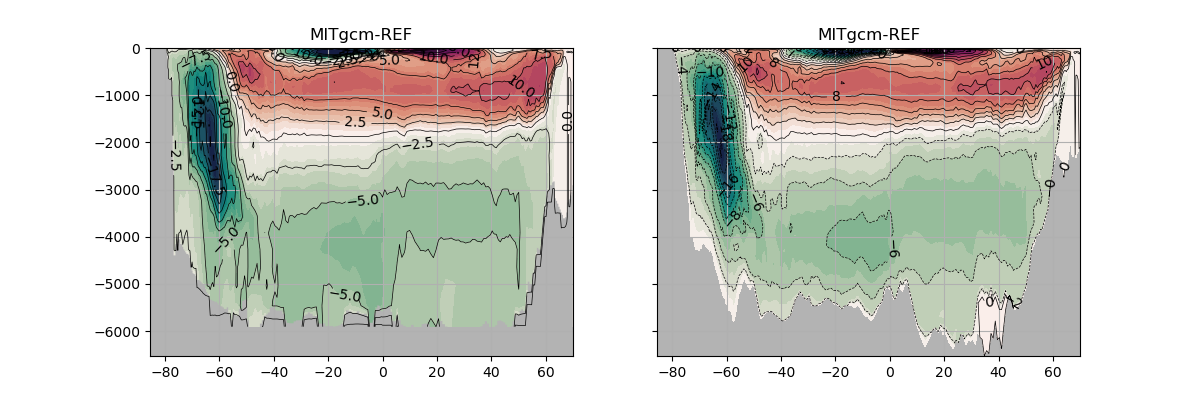

In [11]:
plt.close('all')
global_mask, atlantic_mask, indopacific_mask = make_masks(coords)
msk = atlantic_mask
#msk = indopacific_mask
msk = global_mask

npx, npy = 2,1
fig, ax = plt.subplots(nrows=npy, ncols=npx, sharex=True, sharey=True, figsize=(12,4))
contfs = np.linspace(-20,20,41)
#contfs = np.linspace(-20,20,17)
cmap=cmo.curl
k = 0
hm = plotmoc_remapped_div2(ax[k],dsm[0],dlm[0],msk,contfs,cmap,tstr=fnames[0])
#ax[k].set_xlim([-80,70])
#ax.set_ylim([-6000,0])
k = 1
hm = plotmoc_remapped(ax[k],dsm[0],dlm[0],msk,contfs,cmap,tstr=fnames[0])
#ax[k].set_xlim([-80,70])
#ax[k].set_ylim([-6000,0])

/home/ollie/mlosch/miniconda3/envs/mitgcm/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:641: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/tmp/ipykernel_47321/3795322893.py:11: RuntimeWarning: Mean of empty slice.
  zz = zzz.mean(axis=-1,where=zzz!=0)
/home/ollie/mlosch/miniconda3/envs/mitgcm/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
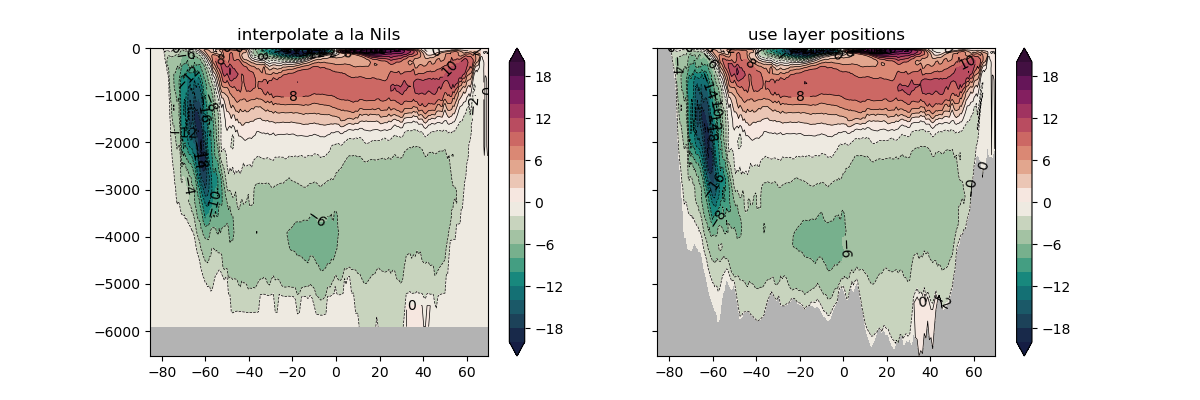

In [13]:
dl=dlm[0]
msk=global_mask
#msk=atlantic_mask
mocstrf = compute_moc_layers(dl,msk)
grd = xgcm.Grid(dl, periodic=False, face_connections=face_connections)
lahc = grd.interp_2d_vector({'X': dl.LaHw1RHO, 
                             'Y': dl.LaHs1RHO},
                             to = 'center', boundary='fill')
lath = 0.5*(lahc['X']+lahc['Y'])*msk
#lath = np.maximum(lahc['X'],lahc['Y'])*msk
zzz = flat2d(lath)
# # mask the Med
# zzz[:,200:217,33:80]=0
# zzz[:,217:222,40:60]=0
#zz = np.ma.masked_array(zzz.cumsum(axis=0),zzz==0)
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    zz = zzz.mean(axis=-1,where=zzz!=0)
zz[np.isnan(zz)]=0 
z = zz.cumsum(axis=0)
#z[zz==0]=0
# The top level coordinate should always be zero (surface),
# but with the cumulative sum, the first value of z is the 
# depth of the first interface; here push down all values to k+1
z = np.roll(z,1,axis=0)
# and make sure that the surface layer is zero
z[0,:]=0
psir_z = np.zeros((dl.Z.shape[0],z.shape[1]))
for jj in range(mocstrf.shape[1]):
    f = interp1d(-z[:,jj], mocstrf[:,jj], bounds_error = False, fill_value=0)
    psir_z[:,jj] = f(dl.Z)

z = compute_layers(dl,msk)
y = xr.concat([coords.YG.isel(face= 0),coords.YG.isel(face= 1),coords.YG.isel(face= 2)], dim='j_g').mean(dim='i_g')
nl = z.shape[0]
yl = np.tile(y.data.reshape((1,y.shape[0])),(nl,1))
#k=55
# mocstrf=mocstrf[:k,:]/
# z = z[:k,:]
# yl = yl[:k,:]
#plt.close('all')
fig,ax=plt.subplots(nrows=1,ncols=2,sharex=True,sharey=True,figsize=(12,4))
hm=ax[0].contourf(y,dl.Z,(psir_z)*1e-6,levels=np.linspace(-20,20,21),cmap=cmo.curl,extend='both')
#hm=ax[0].pcolormesh(y,dl.Z,sq(psir_z)*1e-6,vmin=-20,vmax=20,cmap=cmo.curl)
plt.colorbar(hm,ax=ax[0])
cs=ax[0].contour(y,dl.Z,(psir_z)*1e-6,levels=np.linspace(-20,20,21),colors='k',linewidths=0.5)
ax[0].clabel(cs, cs.levels, inline=True, fontsize=10)
ax[0].set_title('interpolate a la Nils')

hm=ax[1].contourf(yl,-z,(mocstrf)*1e-6,levels=np.linspace(-20,20,21),cmap=cmo.curl,extend='both')
#hm=ax[1].pcolormesh(yl,-z,sq(mocstrf)*1e-6,vmin=-20,vmax=20,cmap=cmo.curl)
plt.colorbar(hm,ax=ax[1])
cs=ax[1].contour(yl,-z,(mocstrf)*1e-6,levels=np.linspace(-20,20,21),colors='k',linewidths=0.5)
ax[1].clabel(cs, cs.levels, inline=True) #, fontsize=10)
ax[1].set_title('use layer positions')

for b in ax: b.set_facecolor('0.7')
